## Inference script 
- frame to video 
- video to frame 

## steps 
- process audio files 
- store all the frames in a folder 
- generate use mediapipe landmarks 
- we will get bbox for each frame for the corresponding N frames [-2+2]
- select the mega box to fit human in it 
- crop all the frames according to mega box and resize it to 256x256 
- rearrange all bboxes to mega box and resize them to 256x256 
- Now pick each frame & crop using bbox of that frame, predict and restore it to the original frame
- merge frames and create a video by adding audio 

In [1]:
import cv2 
import numpy as np
import fastcore.all as fc
from lipsync.create_ds.video_utils import extract_frames
from lipsync.hallo_audio.audio_processor import AudioProcessor
from lipsync.create_ds.mediapipe_landmarks import FaceLandmarks
from lipsync.create_ds.face_mask import get_face_mask, get_union_mask, mask2bbox, make_square_bbox, get_union_bbox
from tqdm import tqdm
from PIL import Image
from moviepy import ImageClip, concatenate_videoclips, AudioFileClip

import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline

In [2]:
#video_path = "weights/data/anshul3-source_25fps_numbered.mp4"
video_path = "videos/video_001.mp4"
audio_path = "../weights/data/anshul-driving-audio-02mins.mp3"

In [3]:
def with_opencv(video_path):
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print("Error: Could not open video.")
        return None
    else:
        fps = video.get(cv2.CAP_PROP_FPS)
        total_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)
        width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video.release()
    return fps, total_frames, (height, width)

fps, total_frames, (height, width) = with_opencv(video_path)
fps, total_frames, (height, width)

(25.0, 900.0, (1440, 2560))

## Process audio 

In [4]:
audio_processor = AudioProcessor(
        16000, 25, "facebook/wav2vec2-base-960h", False, None, None, device="cpu"
    )
audio_emb, _ = audio_processor.preprocess(audio_path)
wav2vec = audio_emb.cpu().numpy()
res_frame_length_based_on_audio = wav2vec.shape[0]
wav2vec.shape, res_frame_length_based_on_audio


Some weights of Wav2VecModel were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


((3004, 12, 768), 3004)

In [5]:
#pad the audio as 1st frame need 2 before frames and last frame need 2 after frames
wav2vec_feature_padding = np.pad(wav2vec, ((2, 2), (0, 0), (0, 0)), mode='edge')
wav2vec_feature_padding.shape

(3008, 12, 768)

## Extract frames 

In [6]:
frames_path = fc.Path("assets/frames")
if not frames_path.exists():
    end_number = res_frame_length_based_on_audio if res_frame_length_based_on_audio < total_frames else total_frames
    extract_frames(video_path, "assets/frames/", start_number=0, step=1, end_number=end_number)
video_frame_path_list = fc.L(fc.Path("assets/frames/").glob("*.png"))
video_frame_path_list.sort()
video_frame_path_list

Extracting Frames:   0%|          | 0/900 [00:00<?, ?it/s]

Saving Frames: 100%|██████████| 900/900 [01:12<00:00, 12.39it/s]



Total time to run extract_frames: 114.05 seconds


(#900) [Path('assets/frames/000000.png'),Path('assets/frames/000001.png'),Path('assets/frames/000002.png'),Path('assets/frames/000003.png'),Path('assets/frames/000004.png'),Path('assets/frames/000005.png'),Path('assets/frames/000006.png'),Path('assets/frames/000007.png'),Path('assets/frames/000008.png'),Path('assets/frames/000009.png')...]

## Extract landmarks 

In [7]:
fl = FaceLandmarks("../weights/face_landmarker.task")
landmarks_save_path = fc.Path("assets/landmarks.npz")
if not fc.Path(landmarks_save_path).exists():
    face_landmarks, hw, frame_numbers = fl.process_frames(video_frame_path_list)
    np.savez(landmarks_save_path, face_landmarks=face_landmarks, hw=hw, frame_numbers=frame_numbers)
else:
    data = np.load(landmarks_save_path, allow_pickle=True)
    face_landmarks, hw, frame_numbers = data["face_landmarks"], data["hw"], data["frame_numbers"]
face_landmarks.shape, hw.shape, frame_numbers.shape

0it [00:00, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1733919554.626704 3644554 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733919555.020983 3647932 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.90.07), renderer: NVIDIA H200/PCIe/SSE2
W0000 00:00:1733919555.021745 3644554 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1733919555.047747 3647934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733919555.067452 3647947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733919555.131352 3647945 landmark_projection_calculator.cc:186] Using NORM_RECT with

((900, 478, 2), (900, 2), (900,))

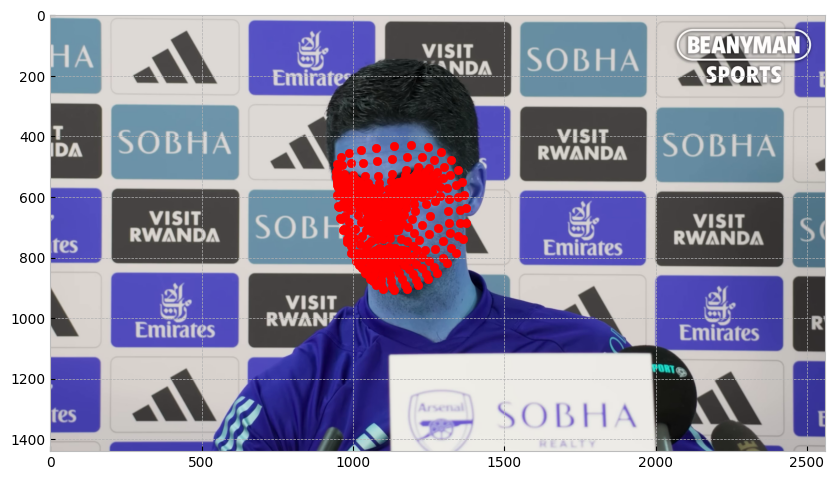

In [8]:
#visualize the landmarks on one frame 
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cv2.imread(str(video_frame_path_list[0])))
ax.scatter(face_landmarks[0, :, 0], face_landmarks[0, :, 1], c="r")
plt.show()

In [9]:
video_frame_path_list_cycle = video_frame_path_list + video_frame_path_list[::-1]
frame_numbers_cycle = np.concatenate([frame_numbers, frame_numbers[::-1]], 0).tolist()
len(video_frame_path_list_cycle), len(frame_numbers_cycle)

(1800, 1800)

In [10]:
video_landmark_data_cycle = np.concatenate([face_landmarks, np.flip(face_landmarks, 0)], 0)
video_landmark_data_cycle.shape

(1800, 478, 2)

In [11]:
video_frame_path_list_cycle_length = len(video_frame_path_list_cycle)
video_frame_path_list_cycle_length

1800

In [12]:
if video_frame_path_list_cycle_length >= res_frame_length_based_on_audio:
    res_video_frame_path_list = video_frame_path_list_cycle[:res_frame_length_based_on_audio]
    res_video_frame_numbers = frame_numbers_cycle[:res_frame_length_based_on_audio]
    res_video_landmark_data = video_landmark_data_cycle[:res_frame_length_based_on_audio, :, :]
else:
    divisor = res_frame_length_based_on_audio // video_frame_path_list_cycle_length
    remainder = res_frame_length_based_on_audio % video_frame_path_list_cycle_length
    res_video_frame_path_list = video_frame_path_list_cycle * divisor + video_frame_path_list_cycle[:remainder]
    res_video_frame_numbers = frame_numbers_cycle * divisor + frame_numbers_cycle[:remainder]
    res_video_landmark_data = np.concatenate([video_landmark_data_cycle]* divisor + [video_landmark_data_cycle[:remainder, :, :]],0)

len(res_video_frame_path_list), res_video_landmark_data.shape, len(res_video_frame_numbers)

(3004, (3004, 478, 2), 3004)

In [13]:
face_landmarks_padded = np.pad(res_video_landmark_data, ((2, 2), (0, 0), (0, 0)), mode='edge')
face_landmarks_padded.shape

(3008, 478, 2)

In [14]:
face_landmarks_padded.shape, len(res_video_frame_numbers), wav2vec_feature_padding.shape

((3008, 478, 2), 3004, (3008, 12, 768))

In [15]:
# req_face_landmarks_padded = face_landmarks_padded[:wav2vec_feature_padding.shape[0]]
# frame_numbers_req = frame_numbers[:wav2vec.shape[0]]
# req_face_landmarks_padded.shape, frame_numbers_req.shape, wav2vec_feature_padding.shape

## get bbox for each frame 

In [16]:
bboxes = []
batch_length = 1
for i in tqdm(range(len(res_video_frame_numbers))): 
    _landmarks = face_landmarks_padded[i:i+batch_length]
    #print(frame_numbers_req[i], _landmarks.shape)
    face_masks = []
    for _l in _landmarks: 
        face_mask, _ = get_face_mask(_l, height, width, expand_ratio=2.3)
        face_masks.append(face_mask)
    
    face_mask = get_union_mask(face_masks)
    face_valid, bbox = make_square_bbox(mask2bbox(face_mask), height, width)
    if not face_valid:
        bboxes.append([0, 0, 0, 0]+[res_video_frame_numbers[i]]+[-1])
        continue 
    bboxes.append(bbox+[res_video_frame_numbers[i]]+[1])

bboxes = np.asarray(bboxes)
print(bboxes.shape)
bboxes

100%|██████████| 3004/3004 [00:04<00:00, 701.45it/s]

(3004, 6)


array([[ 664,  176, 1648, 1160,    0,    1],
       [ 664,  176, 1648, 1160,    1,    1],
       [ 664,  176, 1648, 1160,    2,    1],
       ...,
       [ 720,  109, 1676, 1065,  598,    1],
       [ 722,  111, 1672, 1061,  597,    1],
       [ 719,  112, 1671, 1064,  596,    1]])

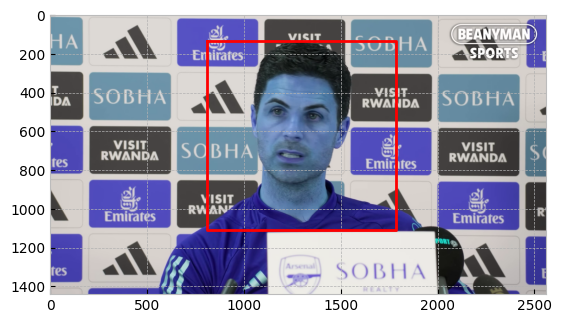

In [17]:
#visualize a frame with bbox    
t = np.random.randint(0, bboxes.shape[0])
x1, y1, x2, y2, frame_number, valid = bboxes[t]
img = cv2.imread(str(fc.Path("assets/frames/")/f"{frame_number:06d}.png"))
plt.imshow(img)
plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], c="r")
plt.show()


In [18]:
def is_bbox_within_image(bbox, height, width):
    min_x, min_y, max_x, max_y = bbox
    return min_x >= 0 and min_y >= 0 and max_x <= width and max_y <= height

def make_large_square_bbox(bbox, height, width):
    min_x, min_y, max_x, max_y = bbox
    size = max(max_x-min_x, max_y-min_y)
    ctr_x = (max_x + min_x) // 2
    ctr_y = (max_y + min_y) // 2
    radius = size // 2
    out = [ctr_x-radius, ctr_y-radius, ctr_x+radius, ctr_y+radius]
    return is_bbox_within_image(out, height, width), out

In [19]:
valid, mega_bbox = make_square_bbox(get_union_bbox(bboxes[:, :4]), height, width)
mega_bbox, valid

([610, 91, 1766, 1247], True)

In [20]:
# check if each bbox is within the mega bbox 
c1 = np.vstack([bboxes[:, 0] >= mega_bbox[0], bboxes[:, 1] >= mega_bbox[1], bboxes[:, 2] <= mega_bbox[2], bboxes[:, 3] <= mega_bbox[3]]).T
c2 = c1.sum(1)
bboxes[c2<4].shape


(829, 6)

In [21]:
valid, mega_bbox = make_large_square_bbox(get_union_bbox(bboxes[:, :4]), height, width)
mega_bbox, valid


([447, -72, 1929, 1410], False)

In [22]:
# if any side is negative, make it positive and check for how to pad the image  
pad_x1 = 0 if mega_bbox[0] >= 0 else -mega_bbox[0]
pad_y1 = 0 if mega_bbox[1] >= 0 else -mega_bbox[1]
pad_x2 = 0 if mega_bbox[2] <= width else mega_bbox[2]-width
pad_y2 = 0 if mega_bbox[3] <= height else mega_bbox[3]-height
pad_x1, pad_y1, pad_x2, pad_y2
pad = [pad_x1, pad_y1, pad_x2, pad_y2]
pad

[0, 72, 0, 0]

In [23]:
mega_bbox = [mega_bbox[0]+pad[0], mega_bbox[1]+pad[1], mega_bbox[2]+pad[2], mega_bbox[3]+pad[3]]
mega_bbox


[447, 0, 1929, 1410]

In [24]:
def resize_bbox(bbox, req_height, req_width, actual_height, actual_width):
    x1 = (bbox[0]/actual_width)*req_width
    y1 = (bbox[1]/actual_height)*req_height
    x2 = (bbox[2]/actual_width)*req_width
    y2 = (bbox[3]/actual_height)*req_height
    return x1, y1, x2, y2


In [25]:
mega_bbox_img = []
relative_bboxes = []
for i in tqdm(bboxes):
    x1, y1, x2, y2, frame_number, valid = i
    # we need to calculate x1, y1, x2, y2 in terms of padded image 
    x1 = x1+pad[0]
    y1 = y1+pad[1]
    x2 = x2+pad[2]
    y2 = y2+pad[3]
    pimg = cv2.imread(str(fc.Path("assets/frames/")/f"{frame_number:06d}.png"))
    #we have pad values along all the directions. [x1, y1, x2, y2]
    img_size = pimg.shape[:2]    
    img = np.uint8(np.zeros((img_size[0]+pad[1]+pad[3], img_size[1]+pad[0]+pad[2], 3)))
    img[pad[1]:pad[1]+img_size[0], pad[0]:pad[0]+img_size[1]] = pimg
    img = img[mega_bbox[1]:mega_bbox[3], mega_bbox[0]:mega_bbox[2]]
    crop_img = cv2.resize(img, (256, 256))[:, :, ::-1]
    mega_bbox_img.append(crop_img)
    x1, y1, x2, y2 = resize_bbox([x1-mega_bbox[0], y1-mega_bbox[1], x2-mega_bbox[0], y2-mega_bbox[1]], 256, 256, mega_bbox[3]-mega_bbox[1], mega_bbox[2]-mega_bbox[0])
    #convert to x1, y1 to lower left corner in int 
    x1, y1 = np.ceil(x1), np.ceil(y1)
    x2, y2 = np.floor(x2), np.floor(y2)
    valid, bbox = make_square_bbox([int(x1), int(y1), int(x2), int(y2)], 256, 256)
    relative_bboxes.append(bbox+([1] if valid else [0]))

relative_bboxes = np.asarray(relative_bboxes)
print(relative_bboxes.shape)


100%|██████████| 3004/3004 [03:47<00:00, 13.23it/s]

(3004, 5)


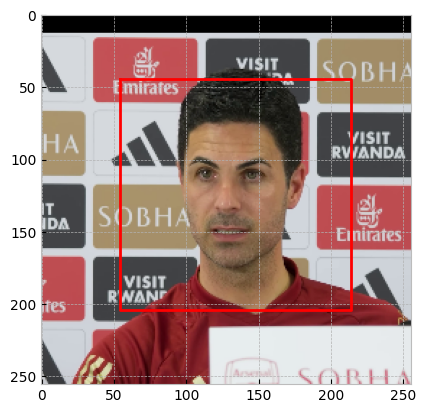

In [26]:
#visuzlize a frame and its bbox 
t = np.random.randint(0, relative_bboxes.shape[0])
x1, y1, x2, y2, valid = relative_bboxes[t]
img = mega_bbox_img[t]
plt.imshow(img)
plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], c="r")
plt.show()

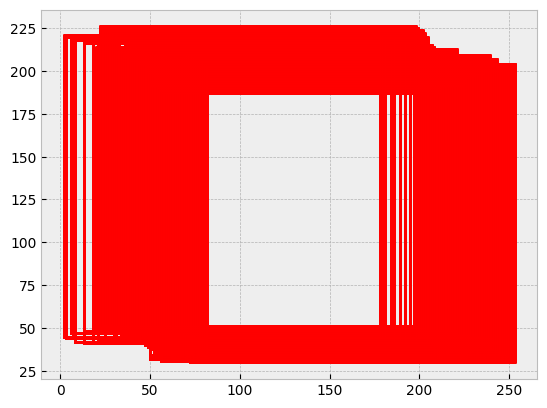

In [27]:
#draw all the bboxes in 2D grid 
for i in range(relative_bboxes.shape[0]):
    x1, y1, x2, y2, valid = relative_bboxes[i]
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], c="r")
plt.show()

In [28]:
relative_bboxes.shape, relative_bboxes[..., -1].sum(), relative_bboxes[relative_bboxes[..., -1]==0]

((3004, 5), 3004, array([], shape=(0, 5), dtype=int64))

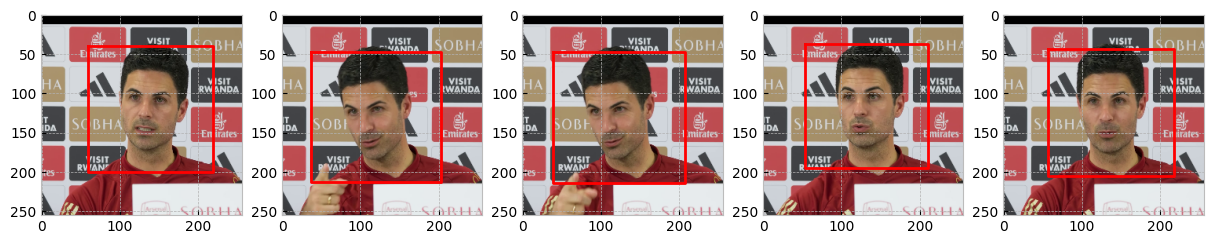

In [29]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=5)
for i in range(5):
    t = np.random.randint(0, relative_bboxes.shape[0])
    ax[i].imshow(mega_bbox_img[t])
    box = relative_bboxes[t]
    ax[i].plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], c="r")
plt.show()

## Load the model 

In [30]:
import torch
from lipsync.dinet.model import DINetSPADE

source_channel = 3
ref_channel = 15
ckpt_path = "../weights/v1/epoch=358-step=255249-val_ep_loss=0.939-train_ep_loss=0.997-val_ep_sync_loss=0.153-train_ep_sync_loss=0.137.ckpt"
model = DINetSPADE(source_channel, ref_channel, upscale=1).cuda()
ckpt = torch.load(ckpt_path, map_location="cpu")
print(ckpt.keys())
ckpt_netg = {k[6:]: v for k, v in ckpt["state_dict"].items() if k.startswith("net_g.")}
model.load_state_dict(ckpt_netg)
model.eval()
print("eval mode set")

/tmp/ipykernel_3644554/1893368788.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])
eval mode set


## Get reference frames 

In [35]:
## select reference frames based on lip-distance based on landmarks 
UPPER_LIP_POINTS = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409]
LOWER_LIP_POINTS = [146, 91, 181, 84, 17, 314, 405, 321, 375, 291]

def get_lip_distance(landmarks):
    upperlip_x = landmarks[:, UPPER_LIP_POINTS, 0]
    upperlip_y = landmarks[:, UPPER_LIP_POINTS, 1]
    lowerlip_x = landmarks[:, LOWER_LIP_POINTS, 0]
    lowerlip_y = landmarks[:, LOWER_LIP_POINTS, 1]
    distances = np.mean(np.sqrt((upperlip_x-lowerlip_x)**2 + (upperlip_y-lowerlip_y)**2), axis=1)
    return distances

distances = get_lip_distance(face_landmarks)
distances.shape


(900,)

In [34]:
len(mega_bbox_img)

3004

In [32]:
#ref_index = np.random.randint(0, relative_bboxes.shape[0], 5)
maxidxs = np.where((distances>np.percentile(distances, 90)) == True)[0] 
minidxs = np.where((distances<np.percentile(distances, 10)) == True)[0]
avgidxs_2 = np.where((distances>np.percentile(distances, 40)) & (distances<np.percentile(distances, 60)) == True)[0]
avgidxs = np.where((distances>np.percentile(distances, 30)) & (distances<np.percentile(distances, 70)) == True)[0]
ref_index = [ np.random.choice(minidxs),  np.random.choice(avgidxs),  np.random.choice(maxidxs),  np.random.choice(minidxs),  np.random.choice(avgidxs)]
ref_frames = [mega_bbox_img[i] for i in ref_index]
ref_bboxes = [relative_bboxes[i] for i in ref_index]
ref_frames_crop = [ref_frames[i][ref_bboxes[i][1]:ref_bboxes[i][3], ref_bboxes[i][0]:ref_bboxes[i][2]] for i in range(len(ref_frames))]
ref_frames_crop = [torch.from_numpy(cv2.resize(i, (256, 256))).permute(2, 0, 1).cuda() for i in ref_frames_crop]
ref_frames_crop = torch.vstack(ref_frames_crop)/255.0
ref_frames_crop.shape

torch.Size([15, 256, 256])

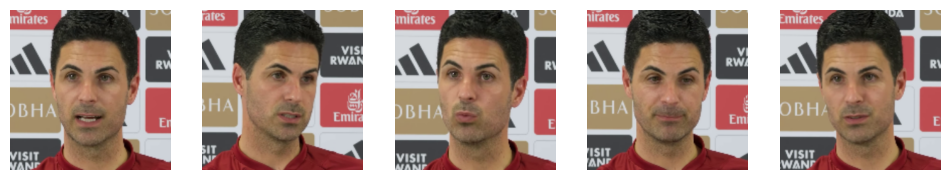

In [33]:
import torchvision
img1 = ref_frames_crop[0:3]
img2 = ref_frames_crop[3:6]
img3 = ref_frames_crop[6:9]
img4 = ref_frames_crop[9:12]
img5 = ref_frames_crop[12:15]
out = []
for img in [img1, img2, img3, img4, img5]:
    out.append(torchvision.transforms.ToPILImage()(img))


fig, ax = plt.subplots(figsize=(12, 3), nrows=1, ncols=len(out))
for n, i in enumerate(out):
    ax.flat[n].imshow(i)
    ax.flat[n].axis("off")
plt.show()

In [281]:
storage_path = fc.Path("assets/storage")
if not storage_path.exists():
    storage_path.mkdir()

for n, i in tqdm(enumerate(relative_bboxes)):
    if n !=381: continue 
    x1, y1, x2, y2, valid = i 
    img = mega_bbox_img[n].copy()
    fimgx = img[y1:y2, x1:x2]
    fimg = cv2.resize(fimgx, (256, 256))/255.0
    fimg = torch.from_numpy(fimg).permute(2, 0, 1).unsqueeze(0).cuda().to(torch.float32)
    audio_emb = torch.from_numpy(wav2vec_feature_padding[n:n+5]).cuda().to(torch.float32)
    with torch.no_grad():
        ref_frames_crop[0:3, :, :] = fimg[0]
        out = model(fimg, ref_frames_crop.unsqueeze(0), audio_emb.unsqueeze(0), mask_dim=[64, 112, 192, 240])
    
    out = out[0].permute(1, 2, 0).detach().cpu().numpy()
    img[y1:y2, x1:x2] = cv2.resize((np.uint8(out*255)), (y2-y1, x2-x1))
    Image.fromarray(img).save(storage_path/f"{n:06d}.png")
    

3004it [00:00, 51659.88it/s]


In [49]:
model.ref_in_conv

Sequential(
  (0): SameBlock2d(
    (conv): Conv2d(15, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): DownBlock2d(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): DownBlock2d(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.2, inplace=True)
  )
)

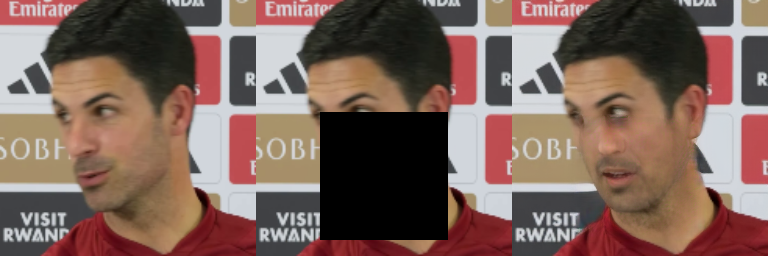

In [282]:
fimg_mask = fimg[0].clone()
mask_dim = [64, 112, 192, 240]
fimg_mask[:, mask_dim[1]:mask_dim[3], mask_dim[0]:mask_dim[2]] = 0
x1 = torchvision.transforms.ToPILImage()(fimg[0])
x2 = torchvision.transforms.ToPILImage()(fimg_mask)
x3 = Image.fromarray(np.uint8(out*255))

#concatenate pil images in a grid  
x = Image.new("RGB", (256*3, 256), (255, 255, 255))
x.paste(x1, (0, 0))
x.paste(x2, (256, 0))
x.paste(x3, (512, 0))
x

In [248]:
fimg.shape

torch.Size([1, 3, 256, 256])

In [249]:
stored_files = fc.L(storage_path.glob("*.png"))
stored_files.sort()
stored_files

(#3004) [Path('assets/storage/000000.png'),Path('assets/storage/000001.png'),Path('assets/storage/000002.png'),Path('assets/storage/000003.png'),Path('assets/storage/000004.png'),Path('assets/storage/000005.png'),Path('assets/storage/000006.png'),Path('assets/storage/000007.png'),Path('assets/storage/000008.png'),Path('assets/storage/000009.png')...]

In [250]:
from moviepy import CompositeVideoClip
def frames_to_video(image_files, audio_path, output_path, fps=25):
    clips = [ImageClip(str(m), duration=1/fps) for m in image_files]
    video = concatenate_videoclips(clips, method="compose")

    audio = AudioFileClip(audio_path)
    final_video = CompositeVideoClip([video])
    final_video.audio = audio
    final_video.write_videofile(output_path, fps=fps, codec='libx264', audio_codec='aac')

In [251]:
frames_to_video(stored_files, audio_path, "assets/res_face_moviepy.mp4")

MoviePy - Building video assets/res_face_moviepy.mp4.
MoviePy - Writing audio in res_face_moviepyTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
MoviePy - Writing video assets/res_face_moviepy.mp4



MoviePy - Done !
MoviePy - video ready assets/res_face_moviepy.mp4
